# Algorithm Comparison

In this notebook we compare the $\hat R$ and the ESS diagnostics of the Random-Walk Metropolis (RWM), Metropolis-Adjusted Langevin Algorithm (MALA) and simplified manifold MALA (smMALA).

In [ ]:
from mcmc_sampling.utils import sym_l2
import numpy as np
import arviz
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from utils import plotting
import mhn
from mhn.mcmc.mcmc import MCMC
from mhn.mcmc.kernels import RWMKernel, MALAKernel, smMALAKernel
import time

import sys
sys.path.append("..")

burn_in = 0.2

/home/lhu/mhn_env/lib/python3.10/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


First, we make some trial runs to infer the time per step for each algorithm.
Note that these might differ on different machines.

In [ ]:
data = np.loadtxt(f"../data/G13_LUAD_12.csv", delimiter=",", skiprows=1,
                  usecols=range(1, 13), dtype=np.int32)
mhn_model = mhn.model.oMHN.load(
    f"../results/mhns/G13_LUAD_12_sym-l2_mle.csv")

speed = dict()

for algo_name, kernel in [
    ("smMALA", smMALAKernel),
    ("RWM", RWMKernel),
    ("MALA", MALAKernel),
]:
    mcmc_sampler = MCMC(
        mhn_model=mhn_model,
        data=data,
        penalty=(sym_l2.sym_l2,
                 sym_l2.sym_l2_grad,
                 sym_l2.sym_l2_hessian),
        kernel_class=kernel,
        step_size=0.0001,
        thin=1,
    )
    n_steps = 10 if algo_name == "smMALA" else 100
    mcmc_sampler.initial_step = np.random.normal(
        size=(mcmc_sampler.n_chains, 1, mcmc_sampler.size),
        scale=1 / np.sqrt(2 * mcmc_sampler.lam))
    t0 = time.time()
    mcmc_sampler.run(max_steps=n_steps)
    t1 = time.time()
    speed[algo_name] = (t1 - t0)/n_steps
    print(f"{algo_name}:\t {(t1 - t0)/n_steps:.5f} seconds per step")

smMALA:	 1.21052 seconds per step
RWM:	 0.06761 seconds per step
MALA:	 0.06838 seconds per step


Now, we compute the $\hat R$ and ESS metrics over the course of the sampling process to produce fig. 2.

In [6]:
samples_rwm = np.load(
    "../results/mcmc/G13_LUAD_12_sym-l2_RWM_0_09999999999999999.npy")
samples_mala = np.load(
    "../results/mcmc/G13_LUAD_12_sym-l2_MALA_0_0018437500000000001.npy")
samples_smmala = np.load(
    "../results/mcmc/G13_LUAD_12_sym-l2_smMALA_0_0325.npy")

In [ ]:
rhat = dict()
ess = dict()
plot_range = dict()

min_steps = min([
    samples.shape[1]
    for samples in [samples_rwm, samples_mala, samples_smmala]])

for algorithm, samples in [("RWM", samples_rwm), ("MALA", samples_mala), ("smMALA", samples_smmala)]:
    step_range = np.linspace(13, min_steps, 30).astype(int)
    time_range = (np.linspace(13, samples_mala.shape[1], 30).astype(int) *
                  speed["MALA"] / speed[algorithm]).astype(int)

    plot_range[algorithm] = np.concatenate([step_range, time_range])
    plot_range[algorithm] = np.sort(np.unique(plot_range[algorithm]))

    plot_range[algorithm] = plot_range[algorithm][plot_range[algorithm] >= 13]

    rhat[algorithm] = np.zeros((len(plot_range[algorithm]), samples.shape[-1]))
    ess[algorithm] = np.zeros((len(plot_range[algorithm]), samples.shape[-1]))
    for i, x in enumerate(plot_range[algorithm]):
        inf_data = arviz.convert_to_inference_data(
            samples[:, int(burn_in * x):x, :])
        rhat[algorithm][i] = arviz.rhat(inf_data).x
        ess[algorithm][i] = arviz.ess(inf_data).x

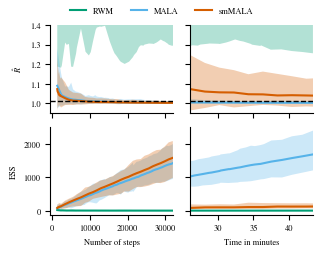

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(3.21, 2.5), sharex="col", sharey="row")
for i in range(2):
    for j in range(2):

        a = ax[i, j]

        for algo_name in rhat.keys():

            metric = rhat if i == 0 else ess

            a.plot(plot_range[algo_name] * 100 * ((speed[algo_name] / 60) ** j),
                   metric[algo_name].mean(axis=1), label=algo_name)
            a.fill_between(plot_range[algo_name] * 100 * ((speed[algo_name] / 60) ** j),
                           metric[algo_name].min(axis=1), metric[algo_name].max(axis=1), alpha=0.3)
        for spine in ["top", "right"]:
            a.spines[spine].set_visible(False)

        if j == 1:
            a.set_xlim(
                min(plot_range["smMALA"] * speed["smMALA"] * 100 / 60),
                max(plot_range["RWM"] * speed["RWM"] * 100 / 60),)
        if i == 0:
            a.set_xlim(None, step_range[-1] * 100)
            a.set_ylim(0.95, 1.4)
            a.axhline(1.01, color='black', linestyle='--', lw=1)
ax[0, 0].set_ylabel("$\hat{R}$")
ax[1, 0].set_ylabel("ESS")
ax[1, 0].set_xlabel("Number of steps")
ax[1, 1].set_xlabel("Time in minutes")

handles, labels = ax[0, 0].get_legend_handles_labels()

legend = fig.legend(handles, labels, loc="upper center", ncol=3,
                    )
legend.get_frame().set_edgecolor('white')
fig.tight_layout()
fig.subplots_adjust(top=0.92)

In [ ]:
fig_width, fig_height = fig.get_size_inches()

legend_y0 = 0.935
upper_y0 = 0.53
right_x0 = 0.55

In [ ]:
fig.savefig("../results/figs/algorithm_comparison_legend.pdf",
            bbox_inches=Bbox.from_bounds(
                x0=0,
                y0=fig_height * legend_y0,
                width=fig_width,
                height=fig_height * (1-legend_y0),))

In [ ]:
legend.set_visible(False)
for index, label in enumerate(["A", "B", "C", "D"]):
    i = index // 2
    j = index % 2
    fig.savefig(f"../results/figs/algorithm_comparison_{label}.pdf",
                bbox_inches=Bbox.from_bounds(
                    x0=0 if j == 0 else right_x0 * fig_width,
                    y0=fig_height * upper_y0 if i == 0 else 0,
                    width=right_x0 * fig_width if j == 0
                    else fig_width - right_x0 * fig_width,
                    height=fig_height *
                    (legend_y0 - upper_y0) if i == 0
                    else fig_height * upper_y0,
                ))

We finally produce some more metrics for the article.

In [ ]:
print("max(R hat) for RWM after 1,000,000 steps:", end=' ')
print(float(arviz.rhat(
    arviz.convert_to_dataset(
        samples_rwm[:, int(samples_rwm.shape[1] * burn_in):])).x.max()))

print("min(ESS) for RWM after 1,000,000 steps:", end=' ')
print(float(arviz.ess(
    arviz.convert_to_dataset(
        samples_rwm[:, int(samples_rwm.shape[1] * burn_in):])).x.min()))

print(f"min(ESS) for MALA after {min_steps * 100} steps:", end=' ')
print(float(arviz.ess(
    arviz.convert_to_dataset(
        samples_mala[:, int(min_steps * burn_in):min_steps])).x.min()))

print(f"min(ESS) for smMALA after {min_steps * 100} steps:", end=' ')
print(float(arviz.ess(
    arviz.convert_to_dataset(
        samples_smmala[:, int(min_steps * burn_in):min_steps])).x.min()))

print("Steps to converge for smMALA:", end=' ')
print(samples_smmala.shape[1] * 100)

print("Time to converge for smMALA:", end=' ')
print(samples_smmala.shape[1] * 100 * speed["smMALA"] / 3600, "h")

print("Steps to converge forMALA:", end=' ')
print(samples_mala.shape[1] * 100)

print("Time to converge for MALA:", end=' ')
print(samples_mala.shape[1] * 100 * speed["MALA"] / 60, "min")

max(R hat) for RWM after 1,000,000 steps: 2.604724594147022
min(ESS) for RWM after 1,000,000 steps: 11.86499336051916
min(ESS) for MALA after 32000 steps: 953.491719824502
min(ESS) for smMALA after 32000 steps: 987.2133880812338
Steps to converge for smMALA: 32000
Time to converge for smMALA: 10.760191175672743 h
Steps to converge forMALA: 38000
Time to converge for MALA: 43.30445567766825 min
